# SegNet  
- Pytorch로 논문 구현  
- Data: CamVid (from Kaggle)
    - Train: 369개, Valid: 100개, Test: 232개
    
- accuracy를 측정할 metric으로는 mIoU score와 BF score를 사용

# Packages and Modules

In [1]:
# packages and modules
import os
import time
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from torchcallback import EarlyStopping, CheckPoint
from torchmetrics import Metrics

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,7]

# Load Data

In [3]:
# 클래스 디렉토리 데이터 불러오기
data = pd.read_csv('./camvid/11_class_dict.csv', index_col=0)
data

r    g    b
name                     
Sky         128  128  128
Building    128    0    0
Pole        192  192  128
Road        128   64  128
Sidewalk      0    0  192
Tree        128  128    0
SignSymbol  192  128  128
Fence        64   64  128
Car          64    0  128
Pedestrian   64   64    0
Bicyclist     0  128  192
unlabelled    0    0    0

In [4]:
rgb_data = {name:list(data.loc[name, :]) for name in data.index}
rgb_array = {idx:np.array(rgb) for idx, (_, rgb) in enumerate(rgb_data.items())}

In [5]:
width = 224
height = 224
num_classes = len(data) # 12 classes (11 object classes and 1 background class)

# cuda setting
device = torch.device('cuda')
print(device)

cuda


In [6]:
# Define a function for loading image with image resize
def load_image_with_resize(path, n_pixel_L, n_pixel_R, subset='train'):
    image_list, label_list = [], []
    image_files = glob(path+subset+'/'+subset+'_images/*.png')
    label_files = glob(path+subset+'/'+subset+'_labels/*.png')
    for file in tqdm(image_files):
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (n_pixel_R, n_pixel_L), cv2.INTER_NEAREST)
        image_list.append(img)
    for file in tqdm(label_files):
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (n_pixel_R, n_pixel_L), cv2.INTER_NEAREST)
        label_list.append(img)
    
    return np.array(image_list), np.array(label_list)

path = './camvid/'
train_image, train_label = load_image_with_resize(path, 
                                                  n_pixel_L=width, n_pixel_R=height, 
                                                  subset='train')
valid_image, valid_label = load_image_with_resize(path, 
                                                  n_pixel_L=width, n_pixel_R=height, 
                                                  subset='valid')
test_image, test_label = load_image_with_resize(path, 
                                                n_pixel_L=width, n_pixel_R=height, 
                                                subset='test')

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

In [7]:
# image to 12 classes mask
def image2mask(labels):
    semantic_map = []
    for color in tqdm(list(rgb_data.values())):
        equality = np.equal(labels, color)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return np.float32(semantic_map)

train_mask = image2mask(train_label)
valid_mask = image2mask(valid_label)
test_mask = image2mask(test_label)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [8]:
# custom data set
class CamVidDataset(Dataset):
    def __init__(self, transforms_, subset='train', predict_train=False):
        self.transforms = transforms.Compose(transforms_)
        if subset=='train':
            if predict_train:
                self.images = train_image[:100]
                self.labels = train_mask[:100]
            else:
                self.images = train_image
                self.labels = train_mask
        elif subset=='valid':
            self.images = valid_image
            self.labels = valid_mask
        else:
            self.images = test_image
            self.labels = test_mask
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        images = self.images[idx]
        labels = self.labels[idx]
        return self.transforms(images), self.transforms(labels)

In [9]:
batch_size = 12

transforms_ = [
    transforms.ToTensor(),
]

train_loader = DataLoader(
    CamVidDataset(transforms_=transforms_, subset='train'),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

valid_loader = DataLoader(
    CamVidDataset(transforms_=transforms_, subset='valid'),
    batch_size=len(valid_image),
    shuffle=True,
    drop_last=True
)

## Build Model

In [10]:
class EncoderBlock(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(EncoderBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(),
        )
        self._init_weight_()
        
    def forward(self, x):
        return self.block(x)
    
    def _init_weight_(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

In [11]:
class DecoderBlock(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(DecoderBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(),
        )
        self._init_weight_()
        
    def forward(self, x):
        return self.block(x)
    
    def _init_weight_(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

In [12]:
class SegNet(nn.Module):
    def __init__(self, in_dim=3, out_dim=num_classes, num_filters=64):
        super(SegNet, self).__init__()
        
        self.vgg16 = models.vgg16(pretrained=True)
        
        self.MaxPooling = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        self.encoder1 = EncoderBlock(in_dim, num_filters)
        self.encoder2 = EncoderBlock(num_filters, num_filters)
        
        self.encoder3 = EncoderBlock(num_filters, num_filters*2)
        self.encoder4 = EncoderBlock(num_filters*2, num_filters*2)
        
        self.encoder5 = EncoderBlock(num_filters*2, num_filters*4)
        self.encoder6 = EncoderBlock(num_filters*4, num_filters*4)
        self.encoder7 = EncoderBlock(num_filters*4, num_filters*4)
        
        self.encoder8 = EncoderBlock(num_filters*4, num_filters*8)
        self.encoder9 = EncoderBlock(num_filters*8, num_filters*8)
        self.encoder10 = EncoderBlock(num_filters*8, num_filters*8)
        
        self.encoder11 = EncoderBlock(num_filters*8, num_filters*8)
        self.encoder12 = EncoderBlock(num_filters*8, num_filters*8)
        self.encoder13 = EncoderBlock(num_filters*8, num_filters*8)
        
        self.get_vgg_weigts()
        
        
        self.UnMaxPooling = nn.MaxUnpool2d(kernel_size=2, stride=2)
        
        self.decoder1 = EncoderBlock(num_filters*8, num_filters*8)
        self.decoder2 = EncoderBlock(num_filters*8, num_filters*8)
        self.decoder3 = EncoderBlock(num_filters*8, num_filters*8)
        
        self.decoder4 = EncoderBlock(num_filters*8, num_filters*8)
        self.decoder5 = EncoderBlock(num_filters*8, num_filters*8)
        self.decoder6 = EncoderBlock(num_filters*8, num_filters*4)
        
        self.decoder7 = EncoderBlock(num_filters*4, num_filters*4)
        self.decoder8 = EncoderBlock(num_filters*4, num_filters*4)
        self.decoder9 = EncoderBlock(num_filters*4, num_filters*2)
        
        self.decoder10 = EncoderBlock(num_filters*2, num_filters*2)
        self.decoder11 = EncoderBlock(num_filters*2, num_filters)
        
        self.decoder12 = EncoderBlock(num_filters, num_filters)
        self.decoder13 = EncoderBlock(num_filters, out_dim)
        
    def forward(self, x):

        size1 = x.size()
        x = self.encoder1(x)
        x = self.encoder2(x)
        x, idx1 = self.MaxPooling(x)

        size2 = x.size()
        x = self.encoder3(x)
        x = self.encoder4(x)
        x, idx2 = self.MaxPooling(x)

        size3 = x.size()
        x = self.encoder5(x)
        x = self.encoder6(x)
        x = self.encoder7(x)
        x, idx3 = self.MaxPooling(x)

        size4 = x.size()
        x = self.encoder8(x)
        x = self.encoder9(x)
        x = self.encoder10(x)
        x, idx4 = self.MaxPooling(x)

        size5 = x.size()
        x = self.encoder11(x)
        x = self.encoder12(x)
        x = self.encoder13(x)
        x, idx5 = self.MaxPooling(x)

        
        x = self.UnMaxPooling(x, idx5, output_size=size5)
        x = self.decoder1(x)
        x = self.decoder2(x)
        x = self.decoder3(x)

        x = self.UnMaxPooling(x, idx4, output_size=size4)
        x = self.decoder4(x)
        x = self.decoder5(x)
        x = self.decoder6(x)

        x = self.UnMaxPooling(x, idx3, output_size=size3)
        x = self.decoder7(x)
        x = self.decoder8(x)
        x = self.decoder9(x)

        x = self.UnMaxPooling(x, idx2, output_size=size2)
        x = self.decoder10(x)
        x = self.decoder11(x)

        x = self.UnMaxPooling(x, idx1, output_size=size1)
        x = self.decoder12(x)
        out = self.decoder13(x)
        
        return out
    
    def get_vgg_weigts(self):
        assert self.encoder1.block[0].weight.size() == self.vgg16.features[0].weight.size()
        self.encoder1.block[0].weight.data = self.vgg16.features[0].weight.data
        assert self.encoder1.block[0].bias.size() == self.vgg16.features[0].bias.size()
        self.encoder1.block[0].bias.data = self.vgg16.features[0].bias.data

        assert self.encoder2.block[0].weight.size() == self.vgg16.features[2].weight.size()
        self.encoder2.block[0].weight.data = self.vgg16.features[2].weight.data
        assert self.encoder2.block[0].bias.size() == self.vgg16.features[2].bias.size()
        self.encoder2.block[0].bias.data = self.vgg16.features[2].bias.data

        assert self.encoder3.block[0].weight.size() == self.vgg16.features[5].weight.size()
        self.encoder3.block[0].weight.data = self.vgg16.features[5].weight.data
        assert self.encoder3.block[0].bias.size() == self.vgg16.features[5].bias.size()
        self.encoder3.block[0].bias.data = self.vgg16.features[5].bias.data

        assert self.encoder4.block[0].weight.size() == self.vgg16.features[7].weight.size()
        self.encoder4.block[0].weight.data = self.vgg16.features[7].weight.data
        assert self.encoder4.block[0].bias.size() == self.vgg16.features[7].bias.size()
        self.encoder4.block[0].bias.data = self.vgg16.features[7].bias.data

        assert self.encoder5.block[0].weight.size() == self.vgg16.features[10].weight.size()
        self.encoder5.block[0].weight.data = self.vgg16.features[10].weight.data
        assert self.encoder5.block[0].bias.size() == self.vgg16.features[10].bias.size()
        self.encoder5.block[0].bias.data = self.vgg16.features[10].bias.data

        assert self.encoder6.block[0].weight.size() == self.vgg16.features[12].weight.size()
        self.encoder6.block[0].weight.data = self.vgg16.features[12].weight.data
        assert self.encoder6.block[0].bias.size() == self.vgg16.features[12].bias.size()
        self.encoder6.block[0].bias.data = self.vgg16.features[12].bias.data

        assert self.encoder7.block[0].weight.size() == self.vgg16.features[14].weight.size()
        self.encoder7.block[0].weight.data = self.vgg16.features[14].weight.data
        assert self.encoder7.block[0].bias.size() == self.vgg16.features[14].bias.size()
        self.encoder7.block[0].bias.data = self.vgg16.features[14].bias.data

        assert self.encoder8.block[0].weight.size() == self.vgg16.features[17].weight.size()
        self.encoder8.block[0].weight.data = self.vgg16.features[17].weight.data
        assert self.encoder8.block[0].bias.size() == self.vgg16.features[17].bias.size()
        self.encoder8.block[0].bias.data = self.vgg16.features[17].bias.data

        assert self.encoder9.block[0].weight.size() == self.vgg16.features[19].weight.size()
        self.encoder9.block[0].weight.data = self.vgg16.features[19].weight.data
        assert self.encoder9.block[0].bias.size() == self.vgg16.features[19].bias.size()
        self.encoder9.block[0].bias.data = self.vgg16.features[19].bias.data

        assert self.encoder10.block[0].weight.size() == self.vgg16.features[21].weight.size()
        self.encoder10.block[0].weight.data = self.vgg16.features[21].weight.data
        assert self.encoder10.block[0].bias.size() == self.vgg16.features[21].bias.size()
        self.encoder10.block[0].bias.data = self.vgg16.features[21].bias.data

        assert self.encoder11.block[0].weight.size() == self.vgg16.features[24].weight.size()
        self.encoder11.block[0].weight.data = self.vgg16.features[24].weight.data
        assert self.encoder11.block[0].bias.size() == self.vgg16.features[24].bias.size()
        self.encoder11.block[0].bias.data = self.vgg16.features[24].bias.data

        assert self.encoder12.block[0].weight.size() == self.vgg16.features[26].weight.size()
        self.encoder12.block[0].weight.data = self.vgg16.features[26].weight.data
        assert self.encoder12.block[0].bias.size() == self.vgg16.features[26].bias.size()
        self.encoder12.block[0].bias.data = self.vgg16.features[26].bias.data

        assert self.encoder13.block[0].weight.size() == self.vgg16.features[28].weight.size()
        self.encoder13.block[0].weight.data = self.vgg16.features[28].weight.data
        assert self.encoder13.block[0].bias.size() == self.vgg16.features[28].bias.size()
        self.encoder13.block[0].bias.data = self.vgg16.features[28].bias.data

In [13]:
model = SegNet().to(device)
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
      EncoderBlock-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 224, 224]          36,928
       BatchNorm2d-6         [-1, 64, 224, 224]             128
              ReLU-7         [-1, 64, 224, 224]               0
      EncoderBlock-8         [-1, 64, 224, 224]               0
         MaxPool2d-9  [[-1, 64, 112, 112], [-1, 64, 112, 112]]               0
           Conv2d-10        [-1, 128, 112, 112]          73,856
      BatchNorm2d-11        [-1, 128, 112, 112]             256
             ReLU-12        [-1, 128, 112, 112]               0
     EncoderBlock-13        [-1, 128, 112, 112]               0
           Conv2d-14    

# Median Frequency Balancing

In [14]:
# class balance of train data set 
train_class_labels = list(rgb_data.keys())
print(train_class_labels)

['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree', 'SignSymbol', 'Fence', 'Car', 'Pedestrian', 'Bicyclist', 'unlabelled']


In [15]:
# median frequency balancing
train_class_count = [2925992, 4164714, 113525, 5769970, 771679, 1666212, 191065, 195738,
                     1040037, 97657, 48378, 607456]
weights = torch.tensor(train_class_count, dtype=torch.float32)
median_weights = weights.median()
median_frequency_balancing = median_weights/weights
print(median_frequency_balancing)

tensor([ 0.2076,  0.1459,  5.3509,  0.1053,  0.7872,  0.3646,  3.1793,  3.1034,
         0.5841,  6.2203, 12.5565,  1.0000])


# Set Loss function, Optimizer, learning rate scheduler and early stopping  

**class imbalance problem**  
- using median frequency balancing  
$$weight = freq\, median \,/\, freq(c)$$  

**loss function**
- loss : weighted cross entropy loss
$$CE = -\sum y_{true}\log\left({y_{pred}}\right)$$  
$$Weighted\,CE = -\sum w\times y_{true}\log\left({y_{pred}}\right)$$

In [16]:
# set learning rate scheduler to reduce loss
lr = 1e-4
es_save_path = './model/es_checkpoint.pt'
cp_save_path = './model/cp_checkpoint.pt'
loss_func = nn.CrossEntropyLoss(weight=median_frequency_balancing).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
checkpoint = CheckPoint(verbose=True, path=cp_save_path)
early_stopping = EarlyStopping(patience=100, verbose=True, path=es_save_path)
metric = Metrics(n_classes=num_classes, dim=1) # mIoU and bf score

# Train Model

In [17]:
# define model training function
def train(model, 
          train_data, 
          validation_data,
          epochs,
          learning_rate_scheduler=False,
          check_point=False,
          early_stop=False,
          last_epoch_save_path='./model/last_checkpoint.pt'):
    # create empty list to append losses and miou of train, valid
    loss_list, miou_list, bf_list = [], [], []
    val_loss_list, val_miou_list, val_bf_list = [], [], []
    # train the model
    model.train()
    starting = time.time()
    # start training
    for epoch in tqdm(range(epochs)):
        init_time = time.time()
        # train by batch
        batch_loss_list, batch_miou_list, batch_bf_list = [], [], []
        for train_images, train_labels in train_data:
            # assign to gpu device
            train_images = train_images.to(device)
            train_labels = train_labels.to(device)
            
            # initialize the gradient to 0
            optimizer.zero_grad()
            # model predict
            output_images = model(train_images)
            loss = loss_func(output_images, train_labels)
            miou = metric.mean_iou(output_images, train_labels)
            bf = metric.f1_score(output_images, train_labels)
            
            # delete memory of gpu
            del train_images
            del train_labels
            torch.cuda.empty_cache()
            
            # update loss and optimizer
            loss.backward()
            optimizer.step()
            
            batch_loss_list.append(loss.item())
            batch_miou_list.append(miou.item())
            batch_bf_list.append(bf.item())
            
        end_time = time.time()
        loss_list.append(loss.item())
        miou_list.append(miou.item())
        bf_list.append(bf.item())
        # check epoch, loss, miou and time
        print(f'\n[Epoch {epoch+1}/{epochs}]'
              f'  [time: {end_time-init_time:.3f}s]'
              f'  [lr = {optimizer.param_groups[0]["lr"]}]')
        print(f'[train loss: {torch.Tensor(batch_loss_list).mean():.3f}]'
              f'  [train mIoU: {torch.Tensor(batch_miou_list).mean():.3f}]'
              f'  [train BF: {torch.Tensor(batch_bf_list).mean():.3f}]')
                
        # validate the model
        vbatch_loss_list, vbatch_miou_list, vbatch_bf_list = [], [], []
        with torch.no_grad():
            for val_images, val_labels in validation_data:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                
                val_outputs = model(val_images)
                val_loss = loss_func(val_outputs, val_labels)
                val_miou = metric.mean_iou(val_outputs, val_labels)
                val_bf = metric.f1_score(val_outputs, val_labels)
                
                del val_images
                del val_labels
                torch.cuda.empty_cache()
                
                vbatch_loss_list.append(val_loss.item())
                vbatch_miou_list.append(val_miou.item())
                vbatch_bf_list.append(val_bf.item())
                
                if learning_rate_scheduler:
                    lr_scheduler.step(epoch+1)
                
            val_loss_list.append(torch.Tensor(vbatch_loss_list).mean())
            val_miou_list.append(torch.Tensor(vbatch_miou_list).mean())
            val_bf_list.append(torch.Tensor(vbatch_bf_list).mean())
            # check loss and miou of validation
            print(f'[valid loss: {torch.Tensor(vbatch_loss_list).mean().item():.3f}]'
                  f'  [valid mIoU: {torch.Tensor(vbatch_miou_list).mean():.3f}]'
                  f'  [valid BF: {torch.Tensor(vbatch_bf_list).mean():.3f}]')
            
        v_loss = torch.Tensor(vbatch_loss_list).mean()
        # save model check point
        if check_point:
            checkpoint(val_loss, model)
        
        # set early stopping
        if early_stop:
            assert check_point==False
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print('\n##########################\n'
                      '##### Early Stopping #####\n'
                      '##########################')
                break
            
    # if we not set early stopping, the model save at the end of training
    if early_stop==False and check_point==False:
        torch.save(model.state_dict(), last_epoch_save_path)
        print('Saving model of last epoch')
        
    ending = time.time()
    print(f'\nTotal time for training is {ending-starting:.3f}s')
    
    return model, loss_list, miou_list, bf_list, val_loss_list, val_miou_list, val_bf_list

In [18]:
# model training
EPOCH = 50

model, train_loss, train_miou, train_bf, valid_loss, valid_miou, valid_bf = train(
    model,
    train_loader,
    validation_data=valid_loader,
    epochs=EPOCH,
    learning_rate_scheduler=False,
    check_point=True,
    early_stop=False,
)

  0%|          | 0/50 [00:00<?, ?it/s]


[Epoch 1/50]  [time: 5.620s]  [lr = 0.0001]
[train loss: 0.992]  [train mIoU: 0.047]  [train BF: 0.149]
[valid loss: 1.604]  [valid mIoU: 0.057]  [valid BF: 0.154]
Validation loss decreased (inf --> 1.604).  Saving model ...

[Epoch 2/50]  [time: 4.643s]  [lr = 0.0001]
[train loss: 0.933]  [train mIoU: 0.081]  [train BF: 0.159]
[valid loss: 1.501]  [valid mIoU: 0.091]  [valid BF: 0.162]
Validation loss decreased (1.604 --> 1.501).  Saving model ...

[Epoch 3/50]  [time: 4.598s]  [lr = 0.0001]
[train loss: 0.881]  [train mIoU: 0.114]  [train BF: 0.167]
[valid loss: 1.405]  [valid mIoU: 0.131]  [valid BF: 0.167]
Validation loss decreased (1.501 --> 1.405).  Saving model ...

[Epoch 4/50]  [time: 4.591s]  [lr = 0.0001]
[train loss: 0.835]  [train mIoU: 0.151]  [train BF: 0.172]
[valid loss: 1.309]  [valid mIoU: 0.165]  [valid BF: 0.172]
Validation loss decreased (1.405 --> 1.309).  Saving model ...

[Epoch 5/50]  [time: 4.606s]  [lr = 0.0001]
[train loss: 0.775]  [train mIoU: 0.183]  [tr

[valid loss: 0.975]  [valid mIoU: 0.486]  [valid BF: 0.223]

[Epoch 48/50]  [time: 5.152s]  [lr = 0.0001]
[train loss: 0.158]  [train mIoU: 0.648]  [train BF: 0.228]
[valid loss: 1.038]  [valid mIoU: 0.476]  [valid BF: 0.222]

[Epoch 49/50]  [time: 4.585s]  [lr = 0.0001]
[train loss: 0.155]  [train mIoU: 0.654]  [train BF: 0.228]
[valid loss: 0.972]  [valid mIoU: 0.489]  [valid BF: 0.223]

[Epoch 50/50]  [time: 4.618s]  [lr = 0.0001]
[train loss: 0.156]  [train mIoU: 0.654]  [train BF: 0.228]
[valid loss: 0.939]  [valid mIoU: 0.488]  [valid BF: 0.223]

Total time for training is 280.188s


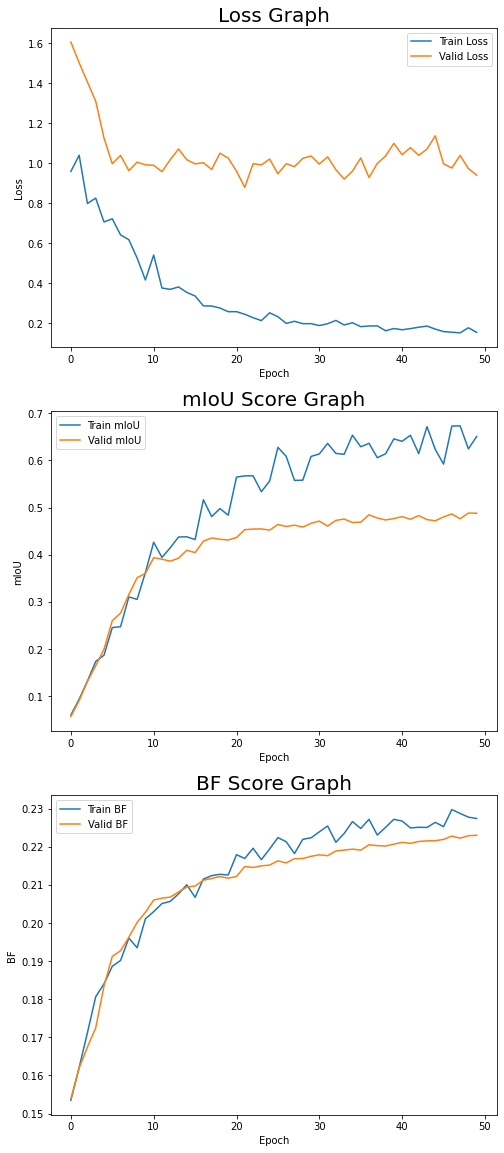

In [19]:
# check losses and miou scores graph
fig, ax = plt.subplots(3,1, figsize=(8,20))
ax[0].set_title('Loss Graph', fontsize=20)
ax[0].plot(np.arange(len(train_loss)), train_loss, label='Train Loss')
ax[0].plot(np.arange(len(valid_loss)), valid_loss, label='Valid Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best')
ax[1].set_title('mIoU Score Graph', fontsize=20)
ax[1].plot(np.arange(len(train_miou)), train_miou, label='Train mIoU')
ax[1].plot(np.arange(len(valid_miou)), valid_miou, label='Valid mIoU')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('mIoU')
ax[1].legend(loc='best')
ax[2].set_title('BF Score Graph', fontsize=20)
ax[2].plot(np.arange(len(train_bf)), train_bf, label='Train BF')
ax[2].plot(np.arange(len(valid_bf)), valid_bf, label='Valid BF')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('BF')
ax[2].legend(loc='best')
fig.show()

# Test (마지막까지 훈련한 모델)

In [20]:
# load test data
test_loader = DataLoader(
    CamVidDataset(transforms_, subset='test'),
    batch_size=len(test_image),
    drop_last=True,
    shuffle=False
)

In [23]:
# test
with torch.no_grad():
    for test_images, test_labels in test_loader:
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)
        # predict
        test_outputs = model(test_images)
        loss = loss_func(test_outputs, test_labels)
        test_miou = metric.mean_iou(test_outputs, test_labels)
        test_bf = metric.f1_score(test_outputs, test_labels)
        print(f'Test Loss: {loss.item():.3f},'
              f'  Test mIoU: {test_miou:.3f},'
              f'  Test BF: {test_bf:.3f}')

Test Loss: 0.539,  Test mIoU: 0.435,  Test BF: 0.216


In [24]:
# 12 classes channels to 3 RGB channels
def map_class_to_rgb(p):
    return rgb_array[p[0]]

def mask2rgb(images):
    rgb_img_list = []
    for img in tqdm(images):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1,2,0))
        img = np.argmax(img, axis=-1)
        rgb_img = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(img, -1))
        rgb_img_list.append(rgb_img)
    return np.array(rgb_img_list)

test_result = mask2rgb(test_outputs)

  0%|          | 0/233 [00:00<?, ?it/s]

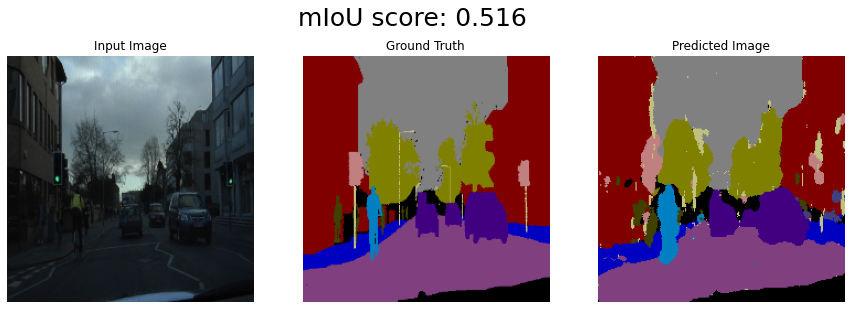

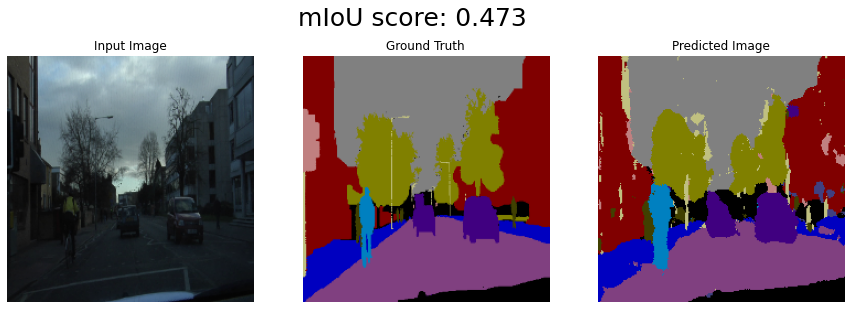

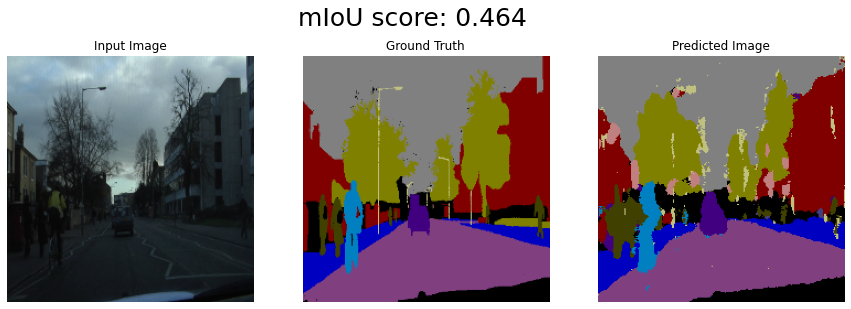

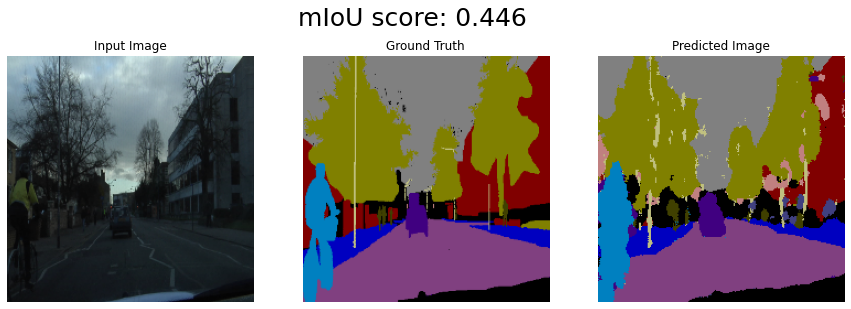

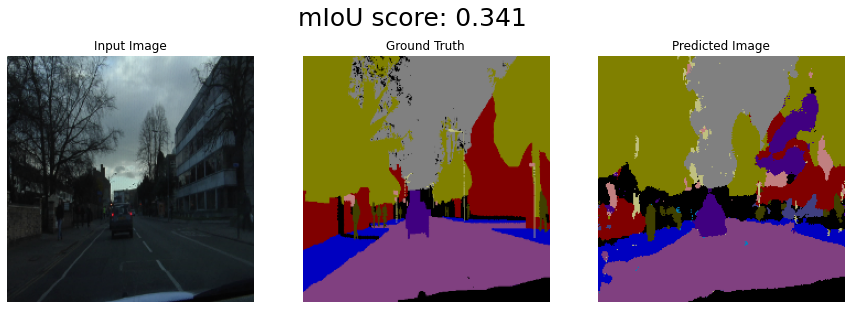

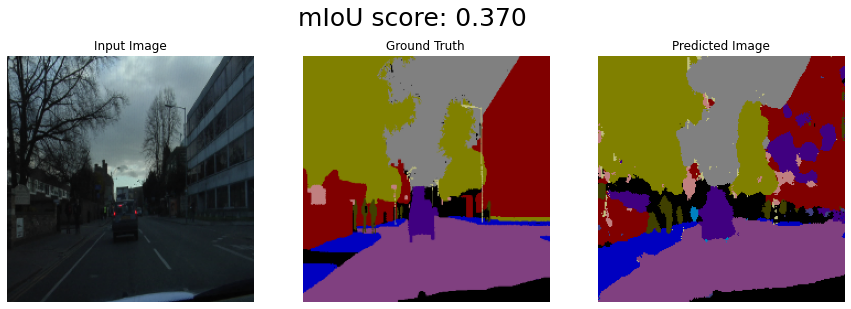

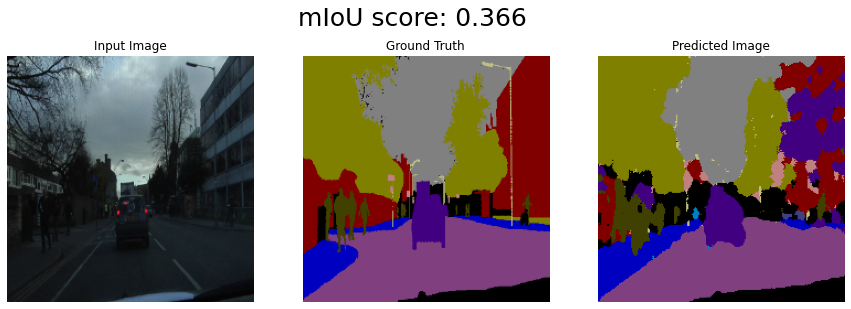

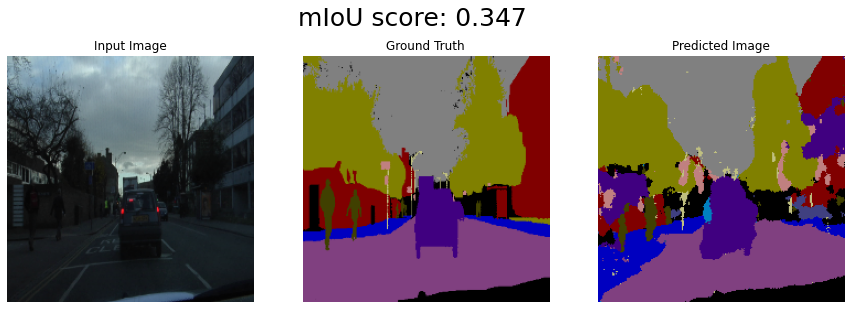

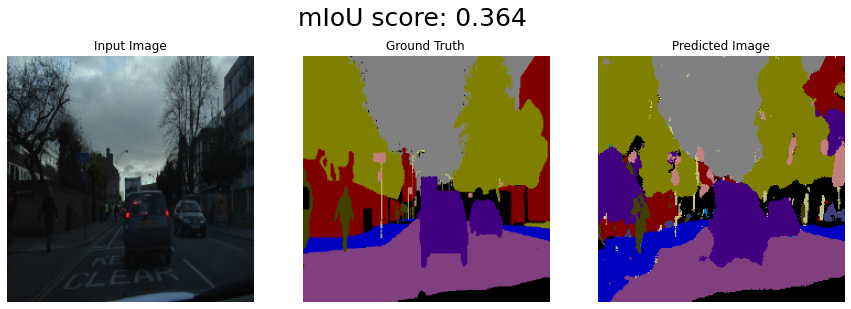

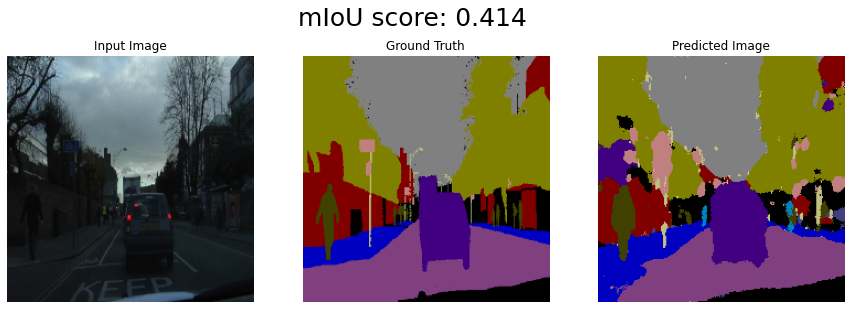

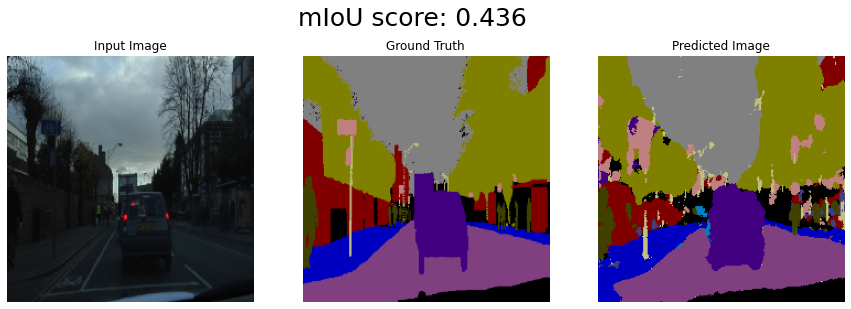

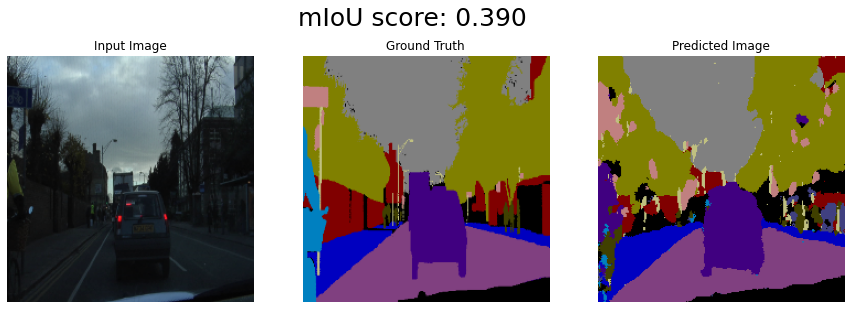

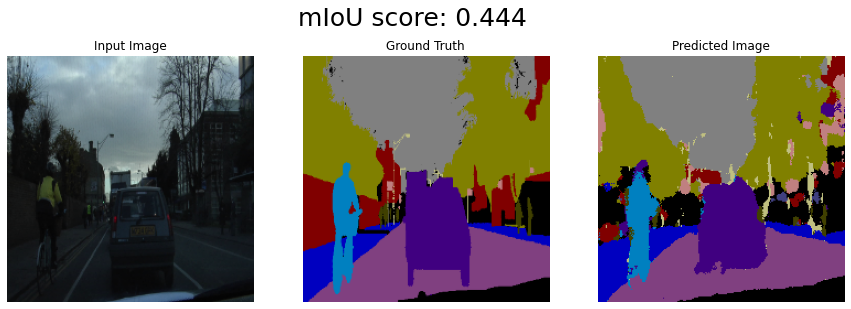

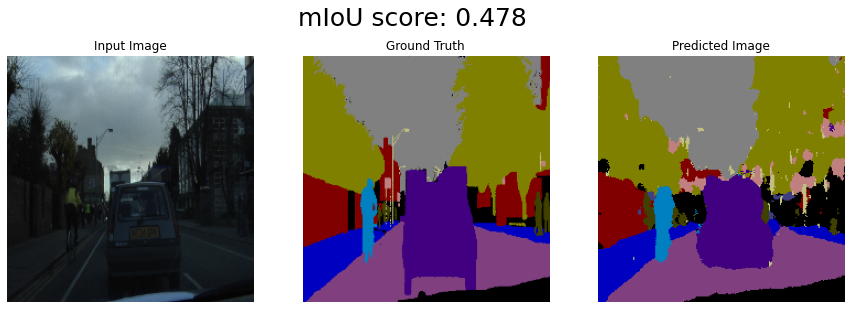

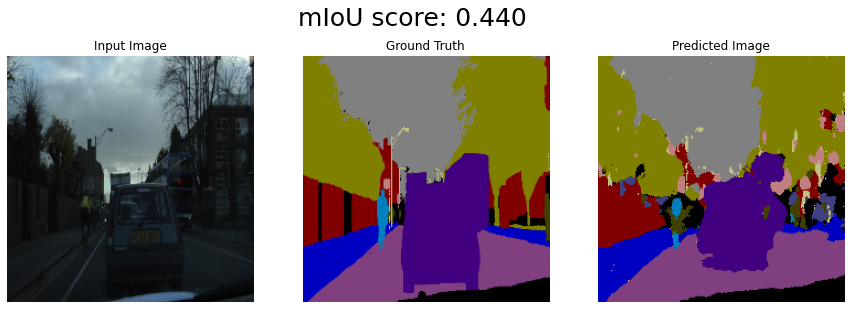

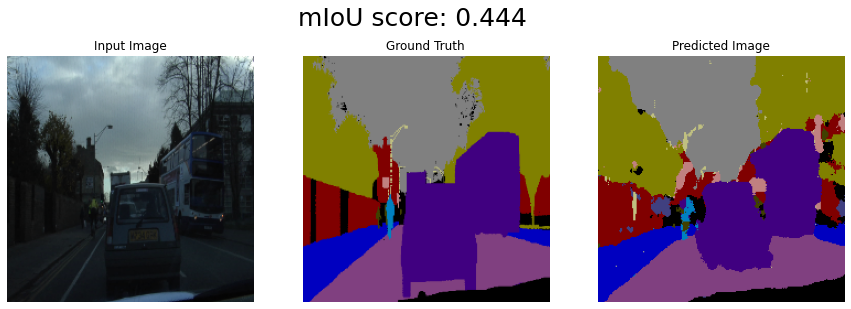

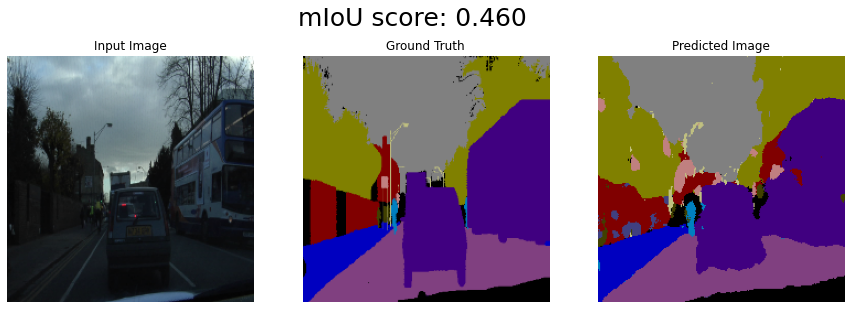

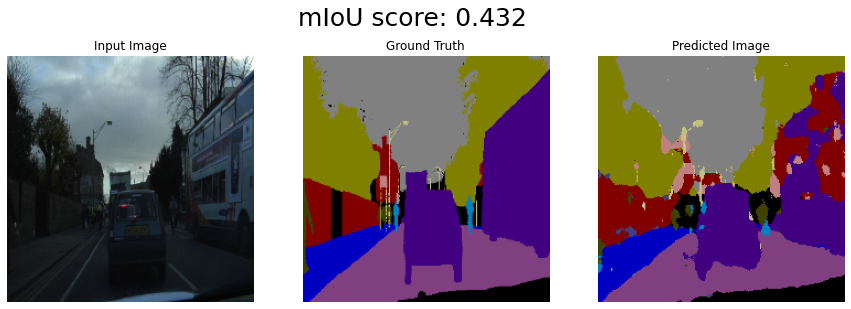

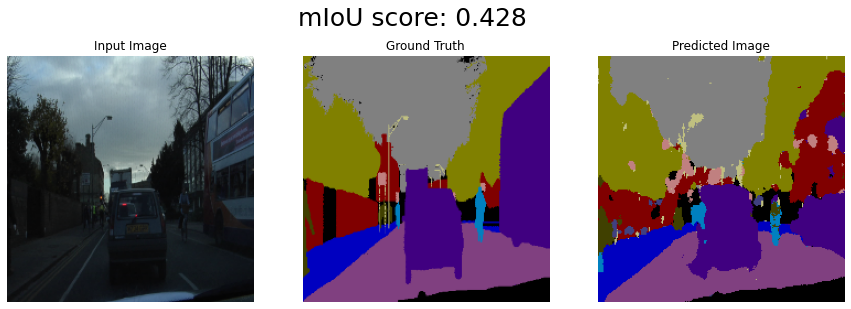

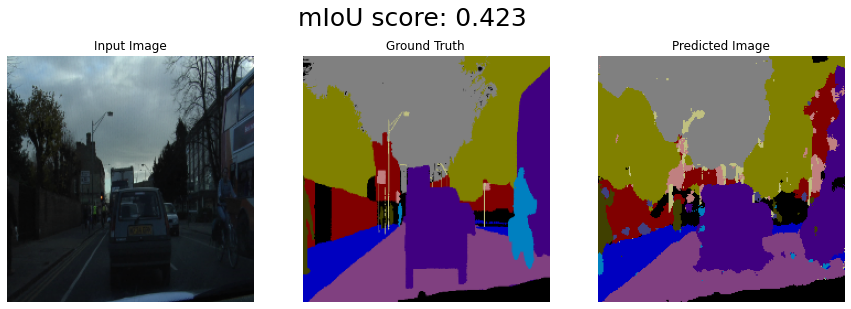

In [26]:
# show test outputs with miou score
test_metric = Metrics(n_classes=num_classes, dim=0)

def show_result(image, label, mask, model_pred, rgb_pred, ncols):
    for i in range(ncols):
        # get miou score
        miou = test_metric.mean_iou(mask[i], model_pred[i])
        # plot images
        fig, ax = plt.subplots(1,3, figsize=(15,5))
        fig.suptitle(f'mIoU score: {miou:.3f}', fontsize=25)
        ax[0].imshow(image[i])
        ax[0].axis('off')
        ax[0].set_title('Input Image')
        ax[1].imshow(label[i])
        ax[1].axis('off')
        ax[1].set_title(f'Ground Truth')
        ax[2].imshow(rgb_pred[i])
        ax[2].axis('off')
        ax[2].set_title(f'Predicted Image')
        fig.show()

show_result(test_image, test_label, test_labels, test_outputs, test_result, 20)

In [27]:
# model이 train data에 대해 잘 훈련됐는지 확인
train_loader = DataLoader(
    CamVidDataset(transforms_=transforms_, subset='train', predict_train=True),
    batch_size=100,
    shuffle=False,
    drop_last=True
)

In [28]:
# test
with torch.no_grad():
    for train_images, train_labels in train_loader:
        train_images = train_images.to(device)
        train_labels = train_labels.to(device)
        # predict
        train_outputs = model(train_images)
        loss = loss_func(train_outputs, train_labels)
        train_miou = metric.mean_iou(train_outputs, train_labels)
        train_bf = metric.f1_score(train_outputs, train_labels)
        print(f'Train Loss: {loss.item():.3f},'
              f'  Train mIoU: {train_miou:.3f},'
              f'  Train BF: {train_bf:.3f}')
        
train_result = mask2rgb(train_outputs)

Train Loss: 0.179,  Train mIoU: 0.658,  Train BF: 0.229


  0%|          | 0/100 [00:00<?, ?it/s]

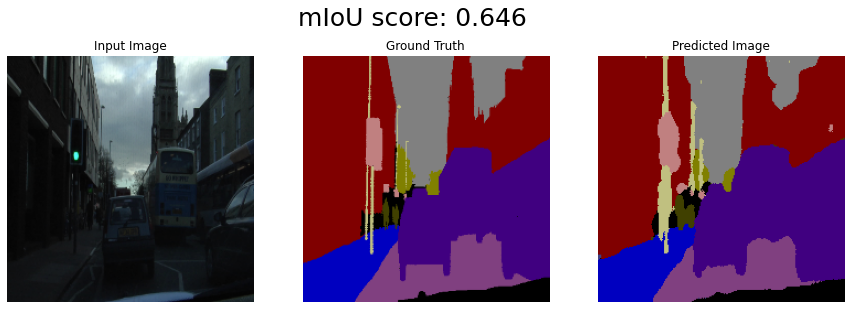

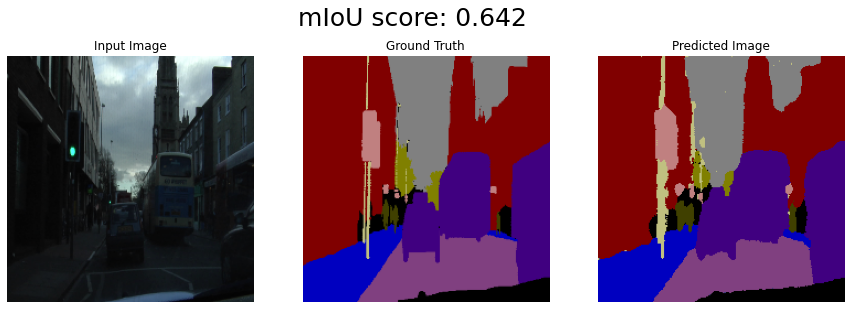

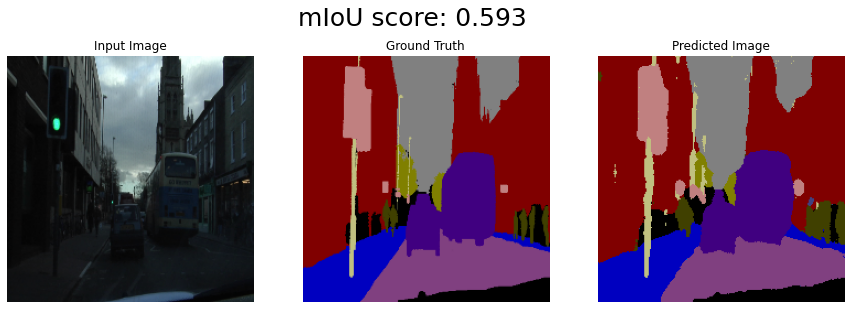

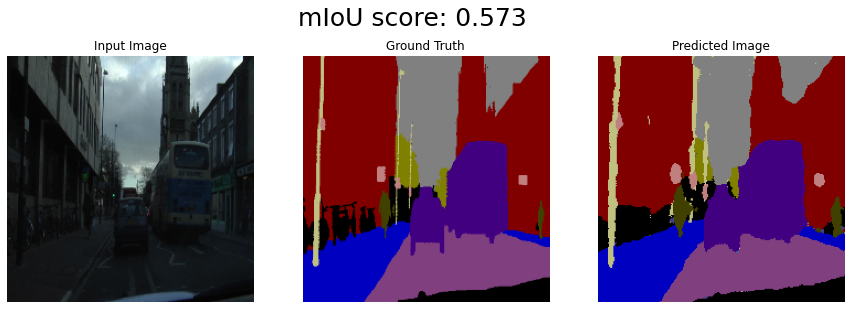

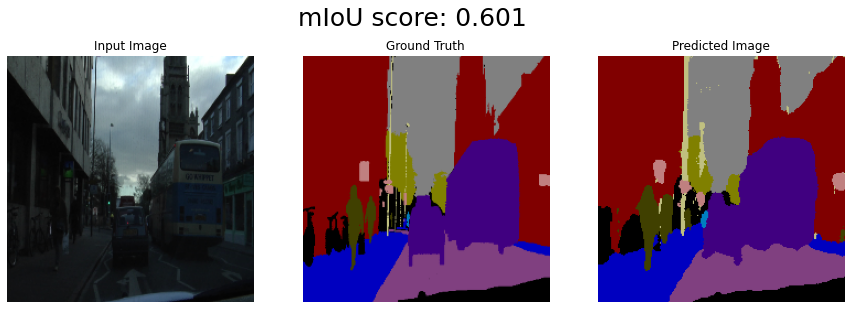

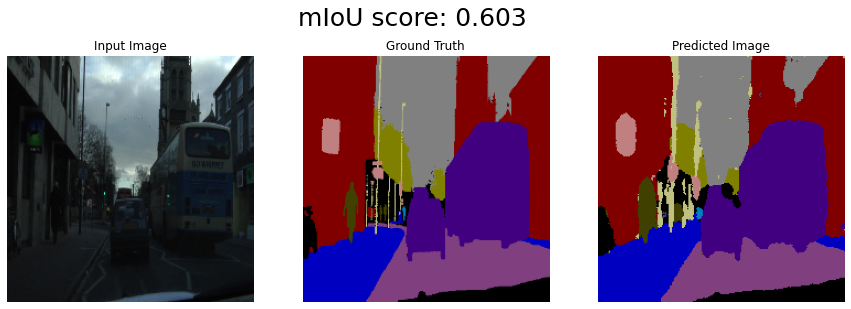

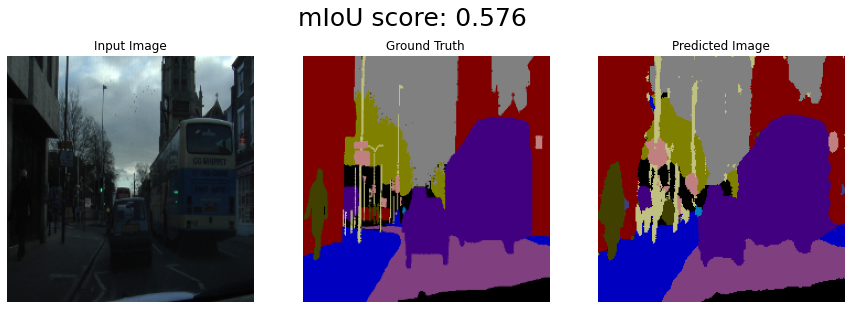

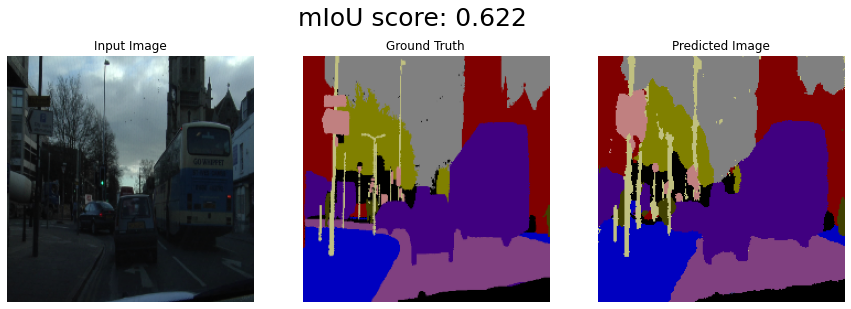

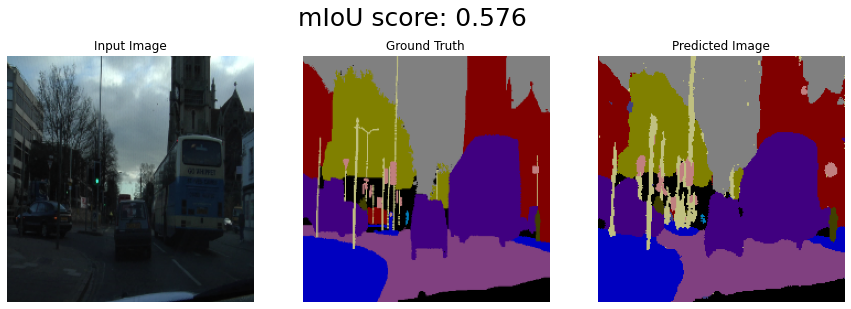

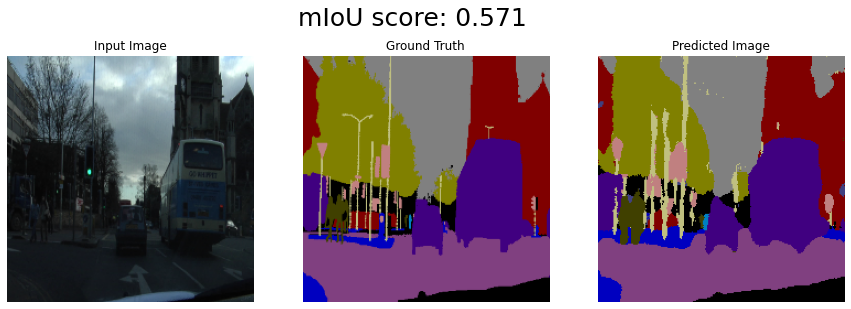

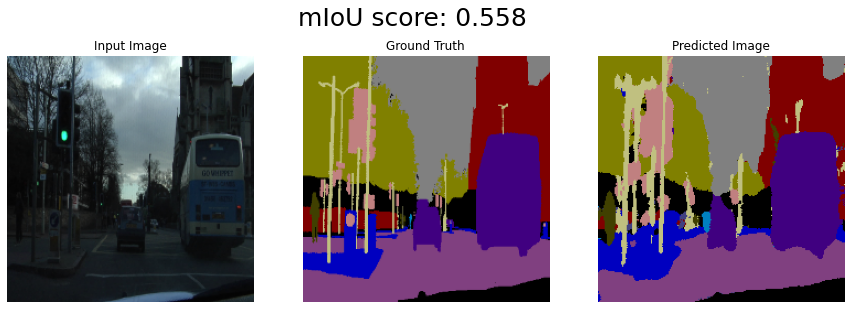

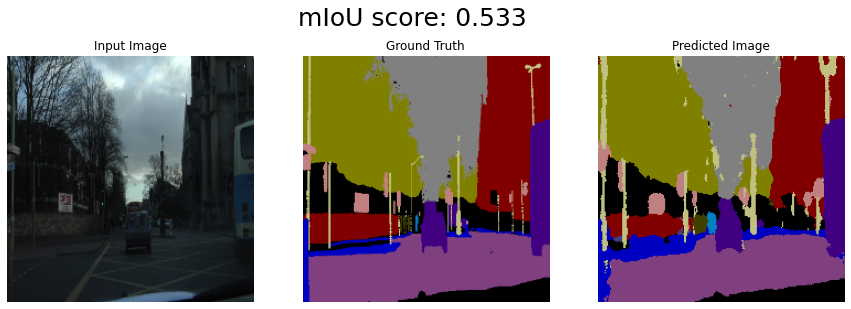

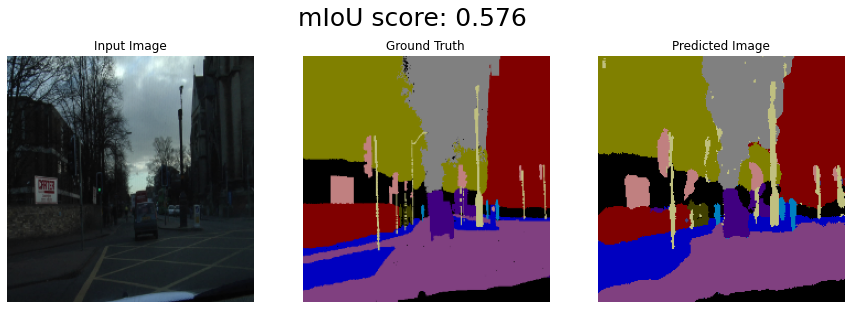

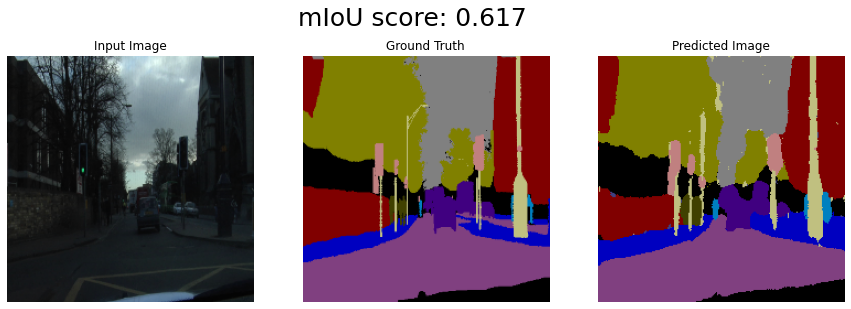

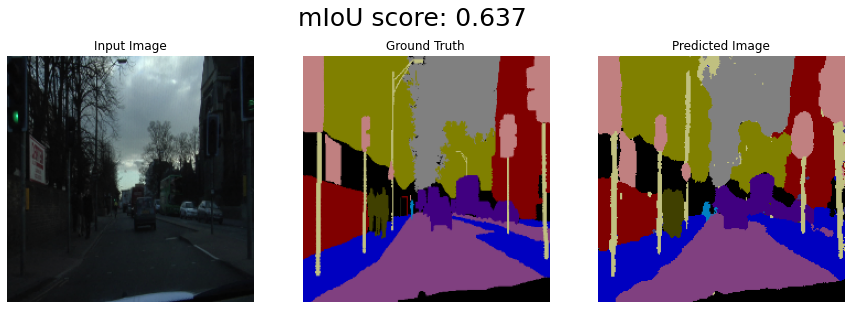

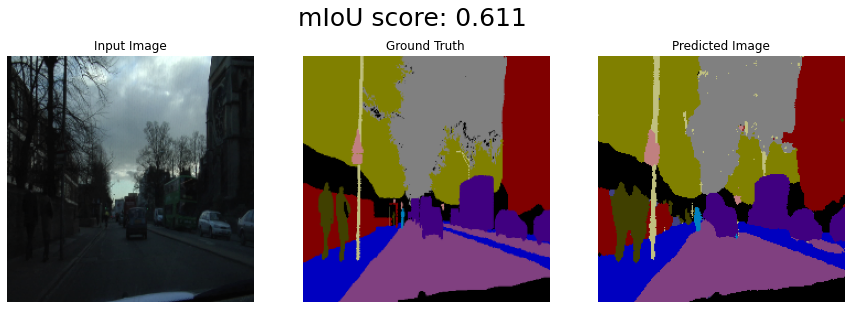

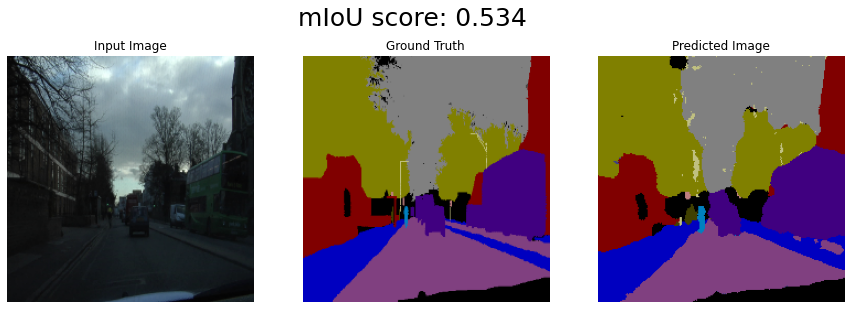

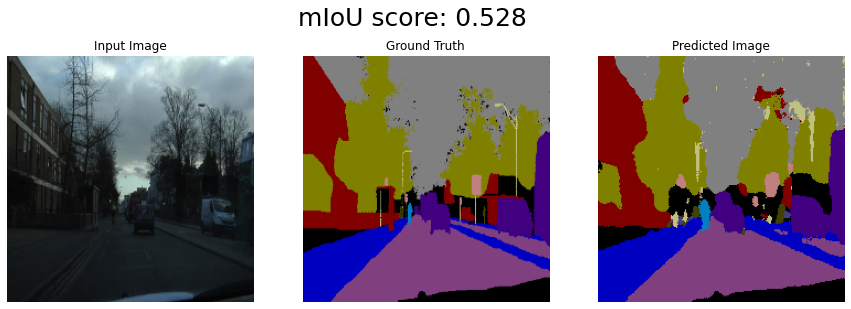

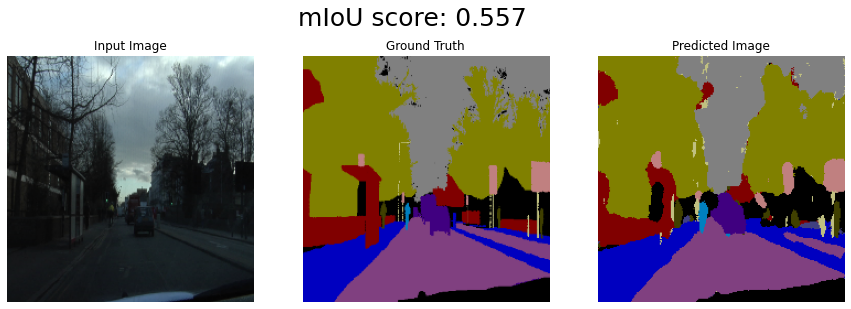

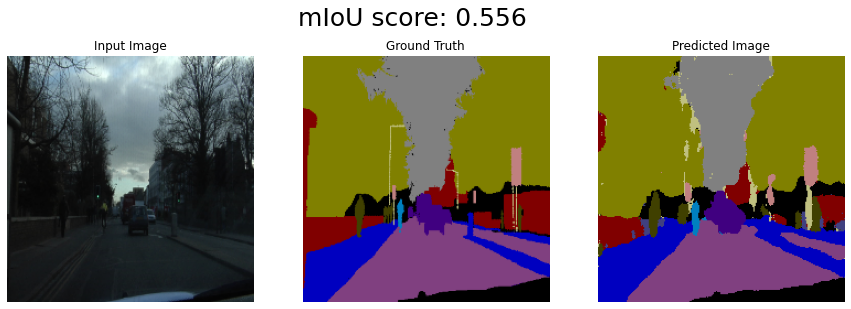

In [29]:
show_result(train_image, train_label, train_labels, train_outputs, train_result, 20)